## Load DataSet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
from keras.datasets import cifar100
from keras.utils import to_categorical
import numpy as np
import cv2
import os
from keras import backend as K

In [4]:
(x_train, y_train_), (x_test, y_test_) = cifar100.load_data()


169009152/169001437 [==============================] - 6s 0us/step


In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

## ResNet18 Model

In [7]:
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.layers import Conv2D, Input
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate
from keras.regularizers import l2
import os

In [8]:
input_shape = (32, 32, 3)
input = Input(shape=input_shape)
x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=l2(1e-4))(input)
x = Activation('elu')(x)

In [9]:
#Stack 1
for block in range(2):
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)

  x = keras.layers.add([y, x])
  x = Activation('elu')(x)

#Stack 2
for block in range(2):
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=32, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=32, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)
  if block == 0:
    x_2 = Conv2D(kernel_size=1, filters=32, strides=1, padding='same')(x)
  else:
    x_2 = x
  x = keras.layers.add([y, x_2])
  x = Activation('elu')(x)

#Stack 3
for block in range(2):
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)
  if block == 0:
    x_2 = Conv2D(kernel_size=1, filters=64, strides=1, padding='same')(x)
  else:
    x_2 = x
  x = keras.layers.add([y, x_2])
  x = Activation('elu')(x)

#Stack 4
for block in range(2):
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=128, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
  y = Activation('elu')(x)
  y = Conv2D(kernel_size=3, filters=128, strides=1, padding='same', kernel_regularizer=l2(1e-4))(y)
  if block == 0:
    x_2 = Conv2D(kernel_size=1, filters=128, strides=1, padding='same')(x)
  else:
    x_2 = x
  x = keras.layers.add([y, x_2])
  x = Activation('elu')(x)

In [10]:
# x = Activation('elu')(x)
x = AveragePooling2D(pool_size=8)(x)
output = Flatten()(x)
output = Dense(100, activation='softmax', kernel_initializer='he_normal')(output)

In [11]:
model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 16)   0           activation[0][0]                 
_______________________________________________________________________________________

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
callback = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/200
391/391 [==============================] - 11s 27ms/step - loss: 3.2832 - accuracy: 0.2312 - val_loss: 3.2482 - val_accuracy: 0.2389
Epoch 2/200
391/391 [==============================] - 11s 27ms/step - loss: 3.1045 - accuracy: 0.2631 - val_loss: 3.0989 - val_accuracy: 0.2664
Epoch 3/200
391/391 [==============================] - 10s 27ms/step - loss: 2.9427 - accuracy: 0.2938 - val_loss: 2.9772 - val_accuracy: 0.2950
Epoch 4/200
391/391 [==============================] - 10s 27ms/step - loss: 2.7921 - accuracy: 0.3241 - val_loss: 2.8546 - val_accuracy: 0.3105
Epoch 5/200
391/391 [==============================] - 10s 27ms/step - loss: 2.6631 - accuracy: 0.3485 - val_loss: 2.7652 - val_accuracy: 0.3300
Epoch 6/200
391/391 [==============================] - 10s 26ms/step - loss: 2.5415 - accuracy: 0.3743 - val_loss: 2.6770 - val_accuracy: 0.3484
Epoch 7/200
391/391 [==============================] - 11s 27ms/step - loss: 2.4349 - accuracy: 0.3974 - val_loss: 2.5944 - val_ac

In [14]:
model.save_weights(filepath=F"/content/gdrive/My Drive/Checkpoints/ResNet18_ADAM_NoRegularization.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


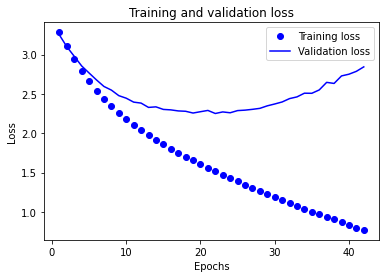

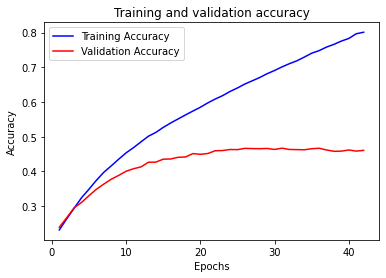

In [15]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt2.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt2.plot(epochs, test_acc, color = 'red', label='Validation Accuracy')
plt2.title('Training and validation accuracy')
plt2.xlabel('Epochs')
plt2.ylabel('Accuracy')
plt2.legend()

plt2.show()

In [17]:
y_pred = model.predict(x_test).argmax(-1)
import sklearn.metrics as metrics
print(metrics.classification_report(y_test.argmax(axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.75      0.52      0.62       100
           1       0.58      0.55      0.56       100
           2       0.29      0.28      0.28       100
           3       0.27      0.32      0.29       100
           4       0.25      0.26      0.25       100
           5       0.42      0.44      0.43       100
           6       0.52      0.57      0.54       100
           7       0.49      0.45      0.47       100
           8       0.67      0.62      0.64       100
           9       0.59      0.57      0.58       100
          10       0.30      0.22      0.25       100
          11       0.32      0.31      0.32       100
          12       0.50      0.46      0.48       100
          13       0.36      0.44      0.40       100
          14       0.47      0.37      0.41       100
          15       0.35      0.35      0.35       100
          16       0.49      0.52      0.50       100
          17       0.71    

## TESTS

In [18]:
# model.load_weights(filepath=F"/content/gdrive/My Drive/Checkpoints/ResNet18_ADAM_NoRegularization.h5")

model.load_weights("ResNet18_ADAM_NoRegularization.h5")

In [19]:
result = model.evaluate(batch_size=128, x=x_test, y=y_test)
dict(zip(model.metrics_names,result))

79/79 [==============================] - 1s 11ms/step - loss: 2.8435 - accuracy: 0.4605


{'accuracy': 0.46050000190734863, 'loss': 2.843470335006714}